In [ ]:
import gym # Importing the OpenAI Gym library for creating environments
import numpy as np  # Importing numpy for numerical operations
import tensorflow as tf # Importing TensorFlow for building neural networks
from tensorflow.keras.models import Sequential # Importing Sequential model for creating a neural network
from tensorflow.keras.layers import Dense # Importing Dense layer for fully connected layers
from collections import deque  # Importing deque for creating a replay buffer
import matplotlib.pyplot as plt  # Importing matplotlib for plotting
import imageio # Importing imageio for creating GIFs


In [ ]:
# Defining Deep Q-Network Model
def create_dqn_model(input_shape, num_actions):
  # Creatinng a sequential model
    model = Sequential([
        Dense(24, input_shape=input_shape, activation='relu'), # Adding a fully connected layer with 24 units and ReLU activation
        Dense(24, activation='relu'),  # Adding another fully connected layer with 24 units and ReLU activation
        Dense(num_actions, activation='linear')  # Adding the output layer with num_actions units and linear activation
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')  # Compiling the model
    return model


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Defining Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)  # Creating a deque with a maximum length

    def add(self, experience):
        self.buffer.append(experience) # Adding  experience to the buffer

    def sample(self, batch_size):
        idx = np.random.choice(len(self.buffer), batch_size, replace=False)  # Randomly sample from the buffer
        return [self.buffer[i] for i in idx]



In [ ]:
# Defining Deep Q-Learning Agent
class DQNAgent:
    def __init__(self, env):
        self.env = env # Storing  the environment
        self.state_shape = env.observation_space.shape  # Getting  the shape of the state space
        self.num_actions = env.action_space.n # Getting the number of possible actions
        self.model = create_dqn_model(self.state_shape, self.num_actions)  # Creating  the DQN model
        self.target_model = create_dqn_model(self.state_shape, self.num_actions) # Creating  the target model
        self.target_model.set_weights(self.model.get_weights())  # Setting  the weights of the target model to match the main model
        self.replay_buffer = ReplayBuffer(capacity=10000) # Creating  a replay buffer
        self.gamma = 0.95 # Setting  the discount factor
        self.epsilon = 1.0 # Setting  the exploration rate
        self.epsilon_decay = 0.995 # Setting the decay rate for exploration
        self.epsilon_min = 0.01 # Setting the minimum exploration rate
        self.batch_size = 32 # Setting  the batch size for training

    def act(self, state):
        if np.random.rand() <= self.epsilon:   # Epsilon-greedy exploration strategy
            return self.env.action_space.sample()
        q_values = self.model.predict(state)  # Using  the model to predict Q-values
        return np.argmax(q_values[0])   # Selecting the action with the highest Q-value

    def train(self, episodes):
        rewards_history = [] # Initializing  list to store rewards history
        for episode in range(episodes):
            state = self.env.reset() # Reseting  the environment
            state = np.reshape(state, [1, self.state_shape[0]])  # Reshaping  the state
            total_reward = 0 # Initializing total reward
            done = False # Initializing flag for episode completion
            while not done:
                action = self.act(state)  # Choosing an action
                next_state, reward, done, _ = self.env.step(action)  # Taking  a step in the environment
                next_state = np.reshape(next_state, [1, self.state_shape[0]])  # Reshaping  the next state
                self.replay_buffer.add((state, action, reward, next_state, done))   # Adding experience to replay buffer
                total_reward += reward  # adding reward
                state = next_state # Updating state
                if len(self.replay_buffer.buffer) > self.batch_size: # Checking  if replay buffer has enough samples for training
                    self.replay()  # Performing a replay step
            rewards_history.append(total_reward) # Appending  total reward to rewards history
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)  # Decaying exploration rate
            if episode % 10 == 0:
                print(f"Episode: {episode}, Reward: {total_reward}, Epsilon: {self.epsilon}")
        return rewards_history

    def replay(self):
        minibatch = self.replay_buffer.sample(self.batch_size)  # Sampling  minibatch from replay buffer
        states, actions, rewards, next_states, dones = zip(*minibatch)  # Unziping minibatch
        states = np.concatenate(states)
        next_states = np.concatenate(next_states)
        targets = self.model.predict(states)
        targets_next = self.target_model.predict(next_states)
        for i in range(len(minibatch)):
            target = rewards[i]
            if not dones[i]:
                target += self.gamma * np.amax(targets_next[i])  # Updating  target with discounted max Q-value of next state
            targets[i][actions[i]] = target  # Updating  target for chosen action
        self.model.fit(states, targets, epochs=1, verbose=0)






        # Updating  target network
        self.update_target_network()

    def update_target_network(self):
        self.target_model.set_weights(self.model.get_weights())  # Updating  weights of target model to match main model

    def save_gif(self, filename):
        frames = []
        state = self.env.reset()  # Reseting  the environment
        state = np.reshape(state, [1, self.state_shape[0]])
        done = False
        while not done:
            frames.append(self.env.render(mode='rgb_array'))  # Rendering  the environment and append frame
            action = self.act(state) # Choosing an action
            next_state, _, done, _ = self.env.step(action)  # Taking a step in the environment
            next_state = np.reshape(next_state, [1, self.state_shape[0]])  # Reshaping  the next state
            state = next_state
        imageio.mimsave(filename, frames)



In [ ]:
# Creating  environment
env = gym.make('CartPole-v1')

# Creating DQN agent
agent = DQNAgent(env)

# Training the agent
episodes = 10
rewards_history = agent.train(episodes)



/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 0, Reward: 30.0, Epsilon: 0.995
1/1 [==============================] - 0s 29ms/step


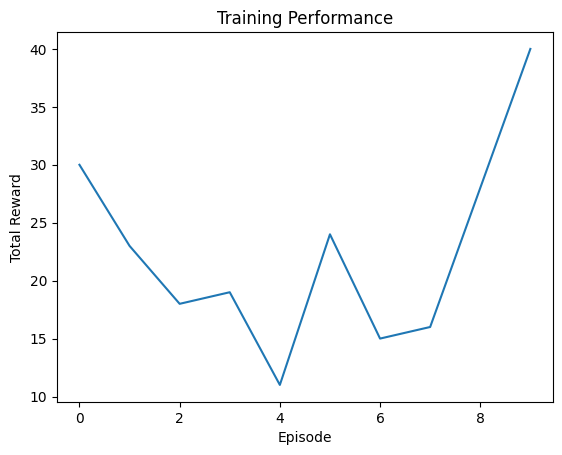

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [ ]:
# Plotting rewards
plt.plot(rewards_history)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Performance')
plt.show()

# Saving GIF of the trained agent's performance
agent.save_gif('cartpole.gif')

# Closing environment
env.close()